# Bayesian Regression

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [ ]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()


# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''
from google.cloud import bigquery
bigquery.USE_LEGACY_SQL = False
from google.cloud.bigquery import magics
magics.context.project = '' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
import datetime


# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

# Relative Importance Package
!pip install relativeImp
from relativeImp import relativeImp

# Fitter package
'''
Fitter package can be used to visualize distributions of data and inform 
parameterization for priors used in bayesian models
'''
!pip install fitter
import fitter
from fitter import Fitter, get_common_distributions


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

## 1) Import dataset

In [ ]:
'''
Import the data using the bigquery magics (%% command). 
Pulls all of the data from the cleaned data table and stores into a dataframe "df"
'''

In [ ]:
%%bigquery df
SELECT *
FROM `.RBA_demo.cleaned_data`; #update project name

In [ ]:
'''
Set the relevant x and y variables to be used in the model.
Add an intercept column
Set the relevant conversion variable as the target 'y1'.
Save all feature variables as 'x'
'''

y = df['y1'] 
x = df.loc[:,df.columns != 'y1']
x['Intercept'] = 1

In [ ]:
x.columns

Index(['x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x16', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'Intercept'],
      dtype='object')

## 2) Run a bayesian RBA model 

In [ ]:
len(x.columns)

In [ ]:
'''
Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).
Hyperparameter tuning can be added into the options section of the query
'''

'''
Initiate a model object using pm.Model() and name as linear_model
'''
with pm.Model() as linear_model:


    '''
    There are two options for setting prior distributions using the pymc3 package.
    
    Option 1: Set each prior distribution individually.

    Option 2: Set all priors to the same distribution or a family of distributions

    Note: This code sets all priors to flat/normal distributions for simplicity. 
    It is recommended to create more informative priors leveraging academic 
    research, business use case, etc. Python's fitter package also provides additional 
    information to underlying data's distribution.
    '''

    '''
    Half distributions are called to constrain coefficient
    output to be positive.

    For RBA, positive coefficient output is informative based on the belief that
    digital media can only positive influence conversions
    '''

    intercept = pm.HalfFlat('Intercept') 
    

    '''
    Option 1: Set individual priors by specifying the variable to parameterize,
    the desired distribution, and corresponding parameters (i.e. mean and variance)

    '''
    #beta1 = pm.Uniform('beta1') #Sample code to set beta1 parameter to uniform dist.


    '''
    Option 2: Set all priors to the same dist. Here, the coefficients for all 
    parameters are constrained to be positive but uniformative using the Half-Flat
    distribution 
    '''

    for z in range(1, len(x.columns)):
      locals()['beta%s' % z] = pm.HalfNormal('beta%s' % z,sigma = y.std())
    
    

    '''
    RBA models are linear and the likelihood function is assumed to take on a normal
    distribution with mean "mu" and standard deviation "sigma".

    In order to estimate the likelihood function, we first need to specify the mean
    and standard deviation.

    The mean is set a linear function mapping our features (digital media tactics)
    and their coefficients (set with priors) and the intercept to our outcome variable (conversions).

    The standard deviation, sigma, is set as a half normal distribution. Standard
    deviation can only be positive, so it is constrained with a halfnormal distribution.
    '''

    mean = (intercept*x['Intercept']) + (beta1 *x['x8']) + (beta2 *x['x9']) + (beta3 *x['x10']) + (beta4 *x['x11']) + (beta5 *x['x12']) + (beta6 *x['x14']) + (beta7 *x['x16']) + (beta8 *x['x26']) + (beta9 *x['x27']) + (beta10 *x['x28']) + (beta11 *x['x29'])+ (beta12 *x['x30']) + (beta13 *x['x32']) + (beta14 *x['x33']) + (beta15 *x['x34'])+ (beta16 *x['x35']) + (beta17 *x['x37']) + (beta18 *x['x38']) + (beta19 *x['x39'])+ (beta20 *x['x40']) + (beta21 *x['x41']) + (beta22 *x['x42']) + (beta23 *x['x43'])+ (beta24 *x['x44']) + (beta25 *x['x45']) + (beta26 *x['x46']) 

    sigma = pm.HalfNormal('sigma', sd = y.std()) 


    '''
    Specify the likelihood function to be estimated with the previously defined
    mean and standard deviation. Observed data will be drawn from a normal distribution
    with mean "mu" and variance sigma

    Set the estimated observed data to be 'Y_obs' and define the observed data to be y (conversions)
    '''

    likelihood = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y)
    

    '''
    To obtain the results of our bayesian model, we must employ sampling methodologies
    to retrieve sample esitmates from the posterior distribution. The posterior
    distribution is developed from information from our priors, likelihood, and 
    the observed data.

    We include two different traces. The normal trace holds the inference data
    in a dataframe with additional information on the chains and sampling.

    The model trace is used for posterior checks and visualization.    
    '''

    normal_trace = pm.sample(return_inferencedata=True, init = 'adapt_diag')
    model_trace = pm.sample(init = 'adapt_diag')


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta26, beta25, beta24, beta23, beta22, beta21, beta20, beta19, beta18, beta17, beta16, beta15, beta14, beta13, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 120 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta26, beta25, beta24, beta23, beta22, beta21, beta20, beta19, beta18, beta17, beta16, beta15, beta14, beta13, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 122 seconds.


In [ ]:
normal_trace.posterior

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 1000)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables: (12/28)
    Intercept  (chain, draw) float64 2.255e+03 2.244e+03 ... 2.242e+03 2.248e+03
    beta1      (chain, draw) float64 2.868 1.763 7.835 ... 0.9212 13.91 8.521
    beta2      (chain, draw) float64 21.75 6.683 13.82 ... 7.526 5.235 4.333
    beta3      (chain, draw) float64 149.8 177.1 142.4 ... 174.0 163.7 161.8
    beta4      (chain, draw) float64 45.78 26.79 27.5 ... 54.81 43.46 49.42
    beta5      (chain, draw) float64 35.64 43.0 60.84 23.27 ... 37.25 45.7 47.66
    ...         ...
    beta22     (chain, draw) float64 31.11 4.728 18.08 ... 0.6911 14.97 24.99
    beta23     (chain, draw) float64 7.354 5.12 1.576 ... 15.93 7.654 16.53
    beta24     (chain, draw) float64 2.566 1.712 3.829 ... 6.433 1.51 6.955
    beta25     (chain, draw) float64 16.14 48.24 36.41 ... 48.08 59.34 45.23
    beta26     (chain, draw) float64 21.84 8.66 35.36 11.6 ... 25.72 26.43 19.36
    sigma      (chain, draw) float64 231.6 219.7 233.1 ... 210.7 240.1 235.7
Attributes:
    created_at:                 2022-01-25T19:50:55.369409
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              119.9064109325409
    tuning_steps:               1000

## 3) Model Results and Evaluation

### 3.1) Posterior Checks

#### 3.1.1) Posterior Predictive Checks Plot

In [ ]:
'''
Posterior predictive checks plot distributions of simulated data from the posterior. 
The amount of simulated data defaults to the number of draws * number of chains during modeling. 

In this case, the default is 1000 draws and 2 chains which creates 2000 simulated 
datasets of observations with the length of observed data. Each chain (also known as a Markov Chain) 
refers to a set of individual sample draws from the posterior distribution. 
Each draw is dependent on the one previous, thus creating a “chain” of values. 
To generate the simulated data, these draws are taken from the posterior distribution of 
parameters and evaluated through the likelihood function. 

The simulated data should align with the observed data to determine a well fitting model. 
Otherwise, the model is misspecified and needs to be revised. If the simulated data (posterior predictive lines) 
align to the observed data (black line) and the highest point of the simulated data 
aligns to the true mean of the observed data (red line) then the model fits the data well.
'''

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


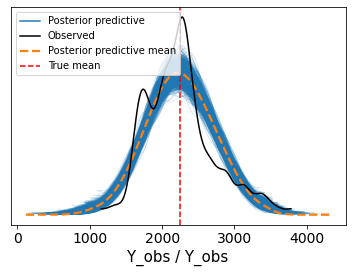

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(normal_trace, ax=ax)
ax.axvline(y.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

#### 3.1.2) Traces Plot

/usr/local/lib/python3.7/dist-packages/arviz/plots/traceplot.py:210: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (28), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f894ee27450>,
      dtype=object)

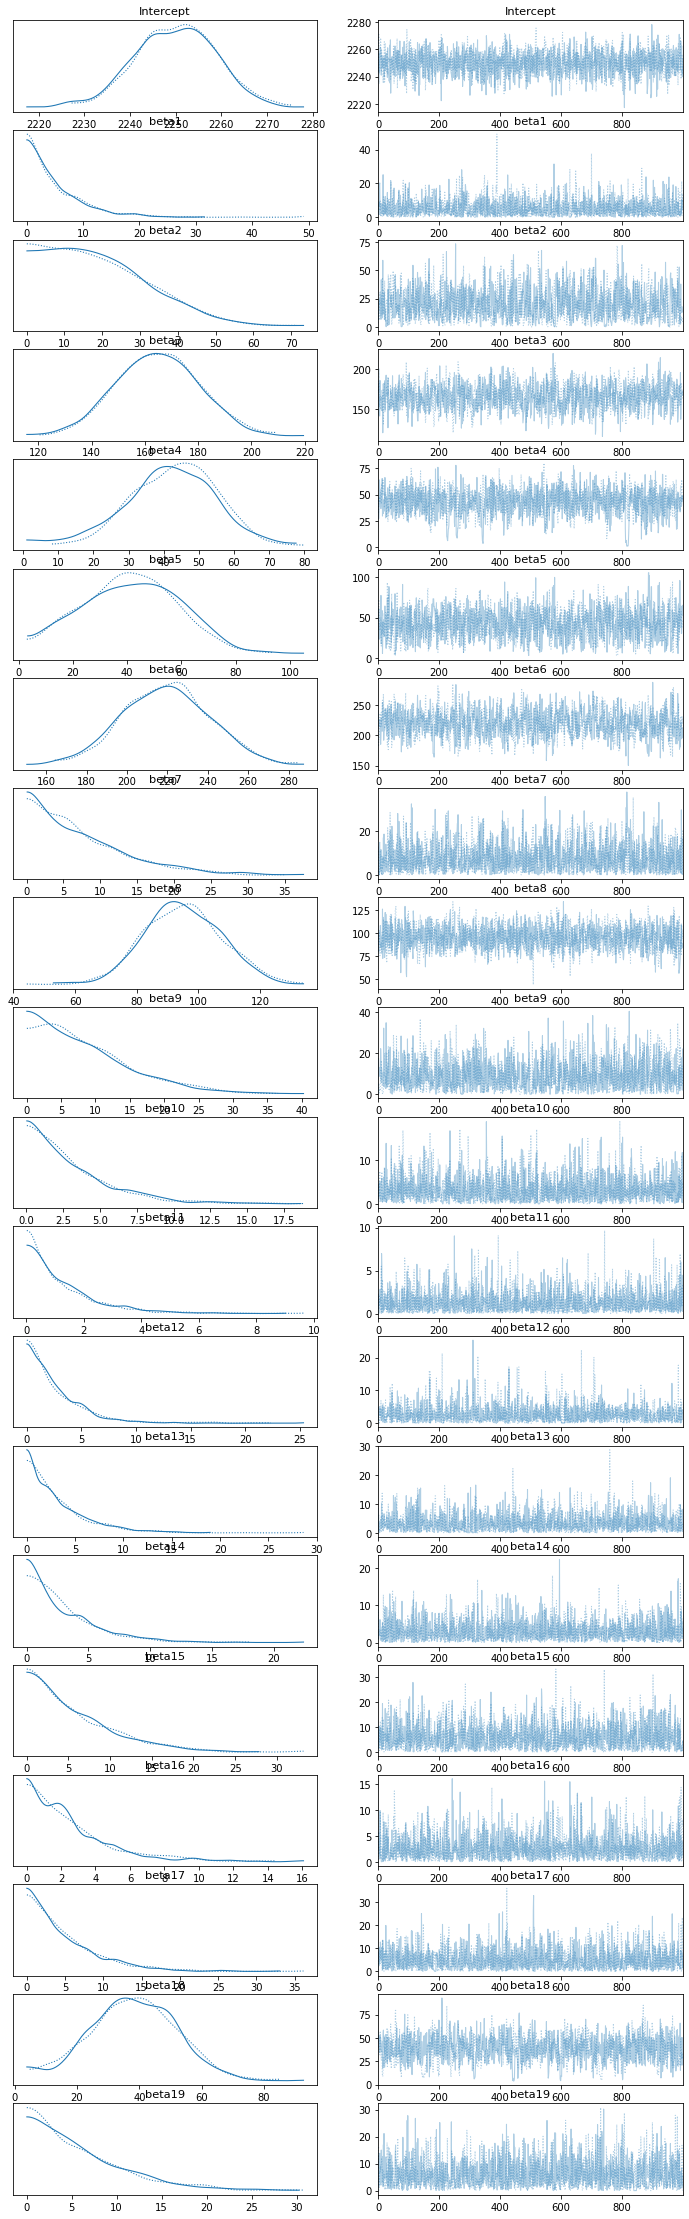

In [ ]:
'''
Trace plots plot the distribution and sampled values for each estimated parameter.
Each line (dotted vs. solid) represents a chain sampled during the MCMC algorithm.

The left hand side shows the kernel density estimate (KDE) plot. For each sampled
parameter along the x-axis, we can see the probability of observing that parameter
value on the y-axis. The plotted lines should follow a similar shape and overlap
to indicate convergence across chains.

The right hand side shows each individual sampled value. It is important to valide 
that the samples are converging around a particular value (on y-axis). This can
be detected by the samples hovering around some constant value, which should match
the maximum density point of the plot on the left-hand side.
'''

az.plot_trace(normal_trace)

#### 3.1.3) Posterior Plots

In [ ]:
'''
Plot the posterior distribution for each parameter estimate, along with the 94% HDI.
The HDI (high density interval) is a credible interval within which an unobserved
parameter value falls with a particular probability. Narrower intervals indicate 
a more precise estimate. HPD/HDI is different from a confidence interval.

“Credible intervals are analogous to confidence intervals in frequentist statistics, 
although they differ on a philosophical basis. Bayesian intervals treat their 
bounds as fixed and the estimated parameter as a random variable, whereas frequentist 
confidence intervals treat their bounds as random variables and the parameter as a fixed value.”

How to interpret: There is a 94% probability that the true (unknown) estimate
would lie within the interval, given the evidence provided by the observed data
'''

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8945fe3710>,
      dtype=object)

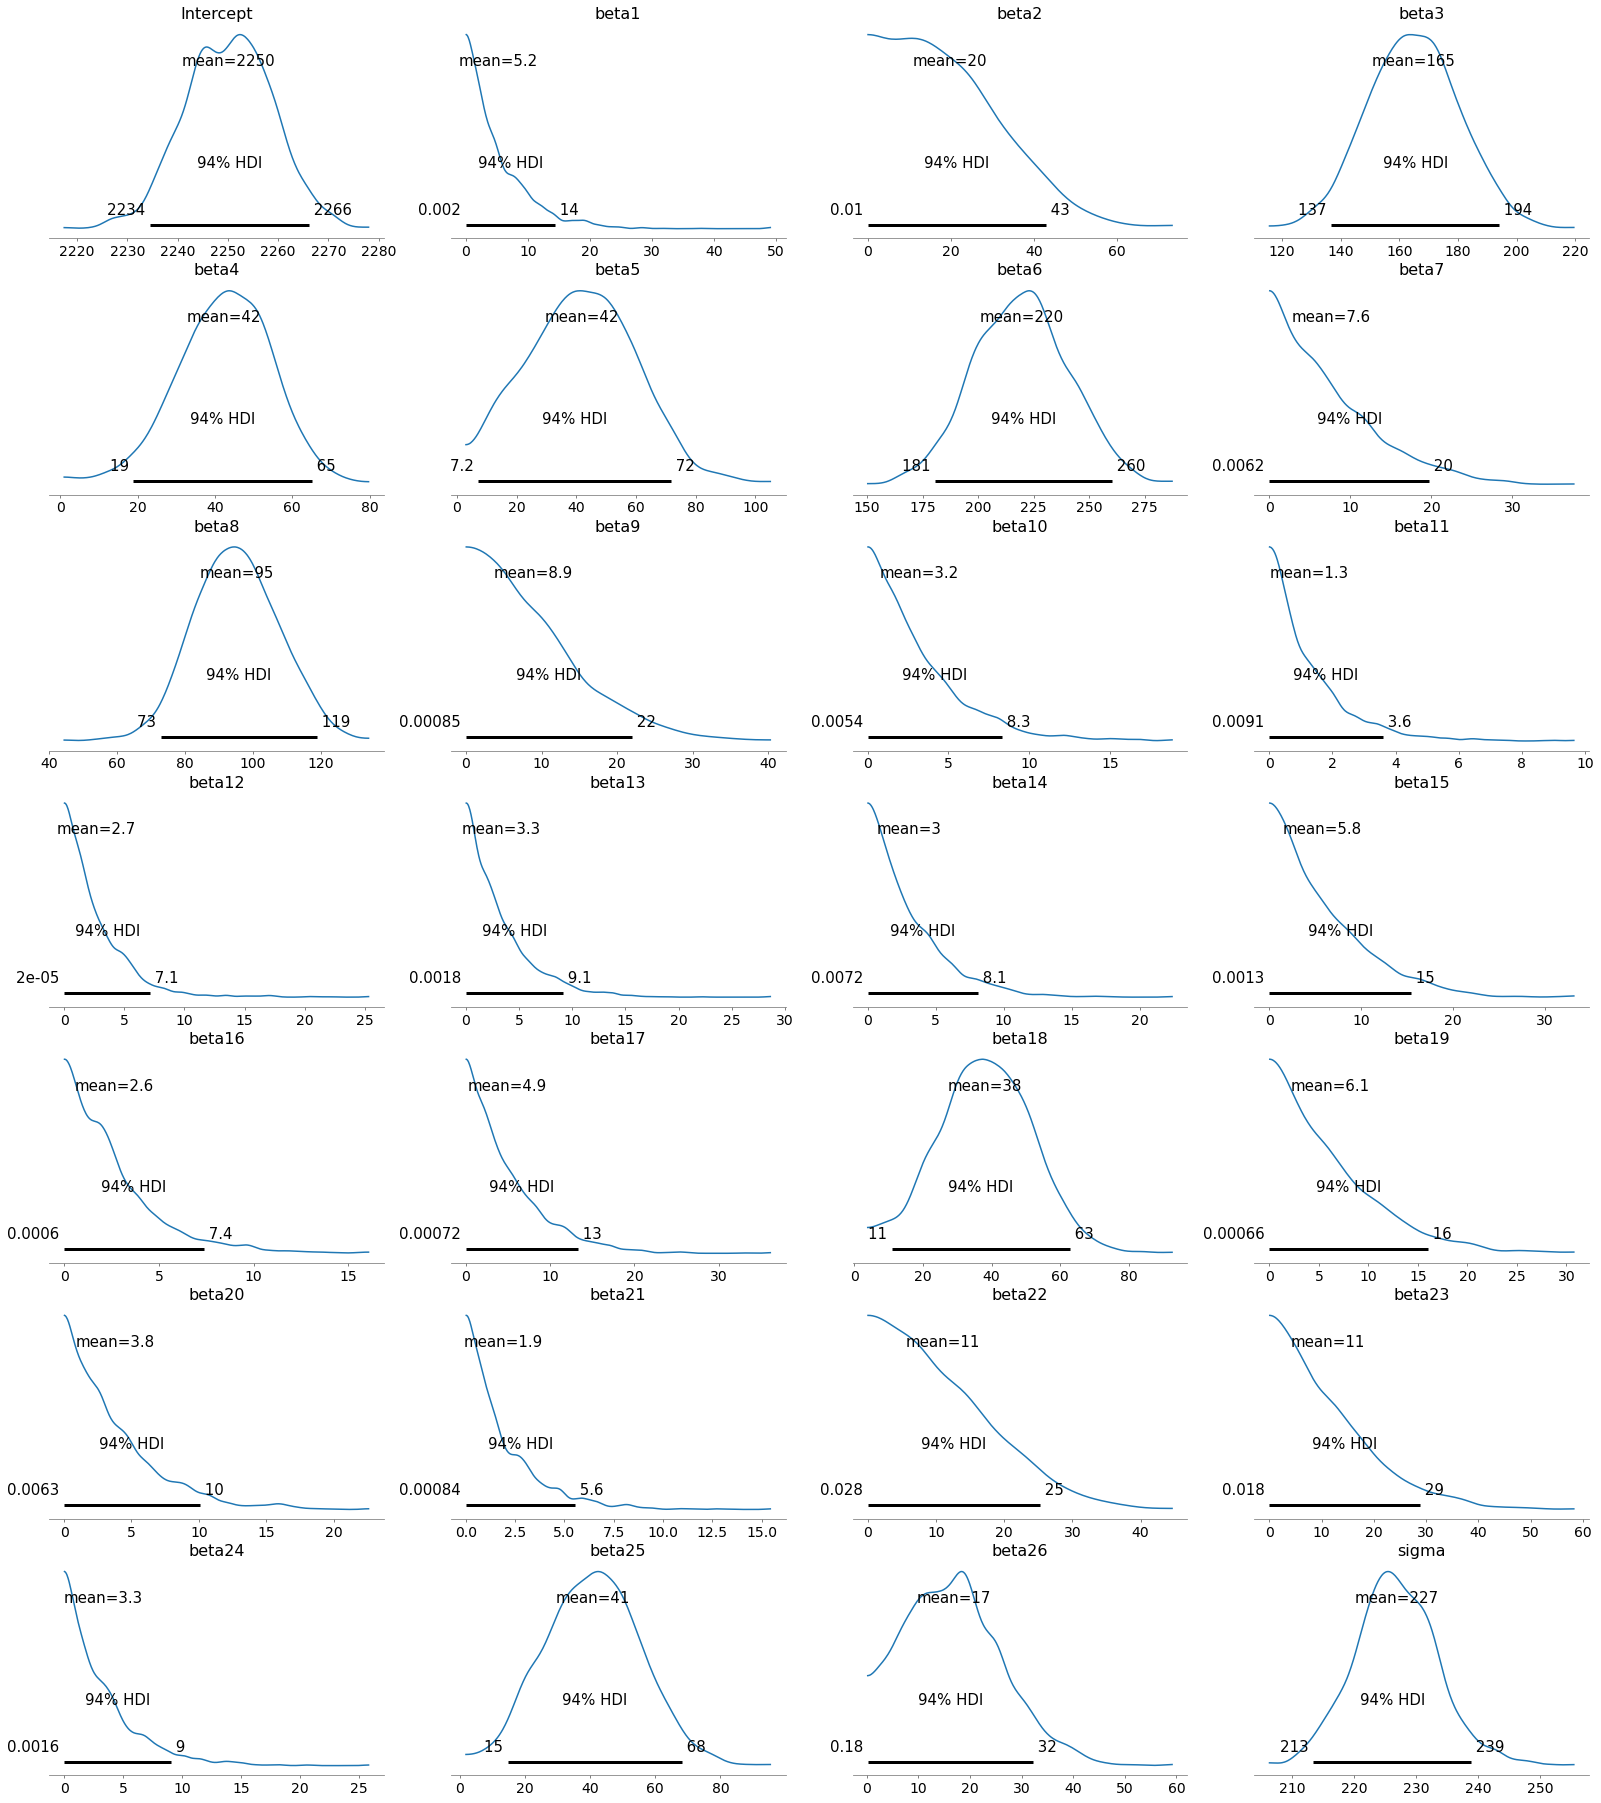

In [ ]:
az.plot_posterior(normal_trace)

#### 3.1.4) Forest Plots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f894cf46710>,
      dtype=object)

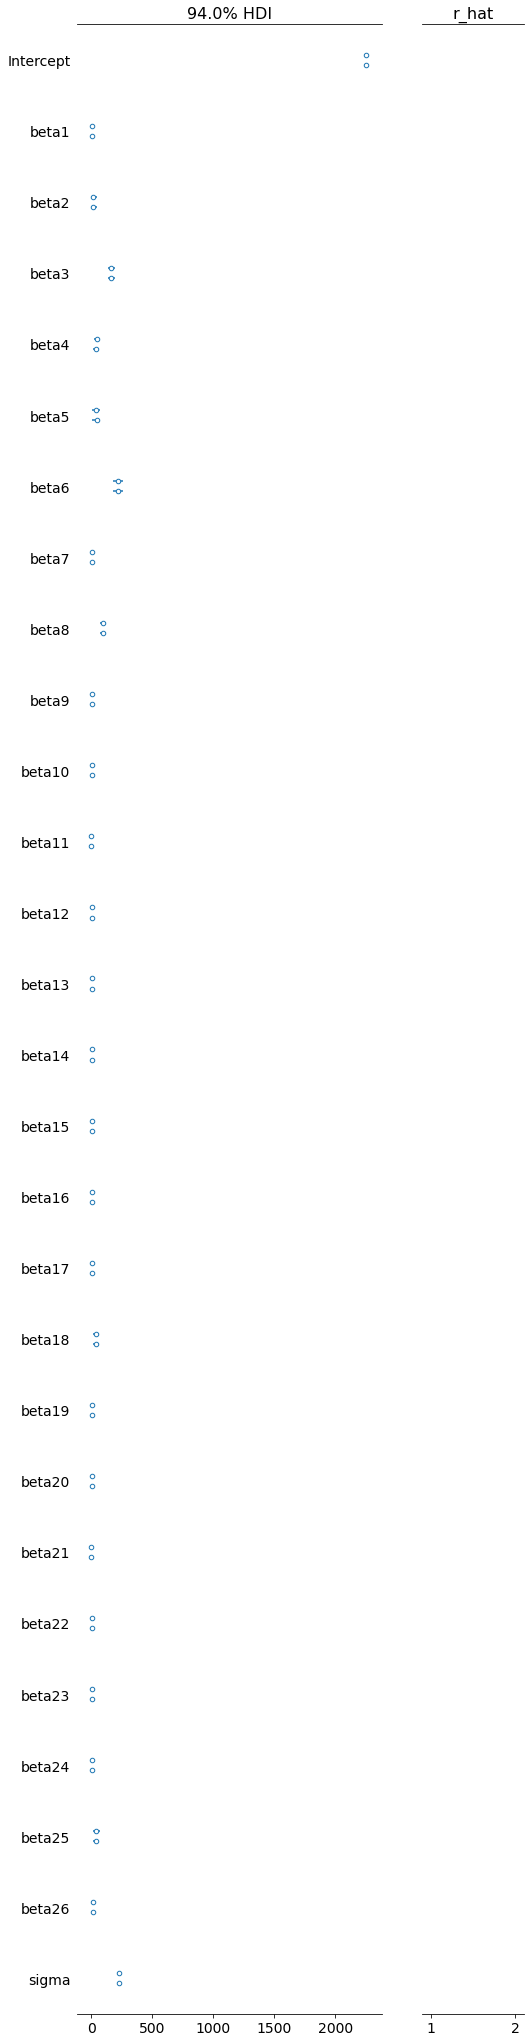

In [ ]:
'''
Forest plot shows each parameter's estimated value along with the 94% HDI.
The range of the interval is indicated by the bars outside of the circle.
The r_hat statistic column shows the convergence of the sampling chains.
The closer to 1, the better convergence of the model.
'''

az.plot_forest(normal_trace, r_hat = True)

#### 3.1.5) MAP estimates

In [ ]:
'''
The MAP estimate shows the mode of the posterior distribution (i.e. the most likely
value of each parameter, based on its sampled distribution)
'''

map_estimate = pm.find_MAP(model=linear_model)
map_estimate

{'Intercept': array(2250.15409512),
 'Intercept_log__': array(7.71875398),
 'beta1': array(2.06990086e-23),
 'beta10': array(6.64575576e-21),
 'beta10_log__': array(-46.46030853),
 'beta11': array(3.92964557e-26),
 'beta11_log__': array(-58.49866318),
 'beta12': array(8.16243062e-22),
 'beta12_log__': array(-48.55733005),
 'beta13': array(9.53881138e-17),
 'beta13_log__': array(-36.8885777),
 'beta14': array(1.16655422e-23),
 'beta14_log__': array(-52.80540285),
 'beta15': array(1.41702588e-15),
 'beta15_log__': array(-34.19021617),
 'beta16': array(2.0187023e-24),
 'beta16_log__': array(-54.55958735),
 'beta17': array(2.71875532e-22),
 'beta17_log__': array(-49.65669787),
 'beta18': array(38.84268846),
 'beta18_log__': array(3.65951986),
 'beta19': array(5.38609252e-17),
 'beta19_log__': array(-37.46012641),
 'beta1_log__': array(-52.23195643),
 'beta2': array(11.21311485),
 'beta20': array(2.809979e-17),
 'beta20_log__': array(-38.11076957),
 'beta21': array(1.20450992e-24),
 'beta21

### 3.2) Metrics

#### 3.2.1) Summary Statistics

In [ ]:
'''
HDI 3% - lower bound of high density interval
HDI 97% - upper bound of high density interval
MCSE Mean and SD - another measure of accuracy of the chains, defined as the
standard deviation o the chains divided by their effective sample size.
ESS - number of samples adjusted for the autocorrelation within a chain
ESS Bulk - effective sample size in the bulk of the posterior distribution
ESS Tail - effective sample size in the tail of the posterior distribution
r_hat - Gelman-Run Statistic (closer to 1 indicates chain convergence)
'''

pm.summary(normal_trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2250.130,8.684,2234.434,2266.169,0.201,0.142,1847.0,1280.0,1.0
beta1,5.231,5.173,0.002,14.345,0.114,0.097,1622.0,1048.0,1.0
beta2,19.691,13.531,0.010,42.829,0.436,0.308,754.0,475.0,1.0
beta3,164.816,15.523,136.746,194.107,0.514,0.364,914.0,1169.0,1.0
beta4,42.382,12.397,18.958,65.227,0.455,0.322,825.0,477.0,1.0
beta5,41.904,18.198,7.164,71.743,0.574,0.406,977.0,955.0,1.0
beta6,219.572,21.455,180.645,260.351,0.772,0.546,769.0,843.0,1.0
beta7,7.564,6.382,0.006,19.678,0.166,0.133,1510.0,1127.0,1.0
beta8,95.143,12.512,72.913,118.855,0.304,0.215,1691.0,1266.0,1.0
beta9,8.866,7.001,0.001,21.906,0.170,0.120,1266.0,850.0,1.0


#### 3.2.2) Bayesian Evaluation Metrics and CV

##### 3.2.2.1) BFMI (Bayesian Fraction of Missing Information)

In [ ]:
'''
A way of determining efficient sampling for each chain. Values smaller than 0.3
indicate poor sampling
'''
pm.bfmi(normal_trace)

array([0.89839383, 0.8721527 ])

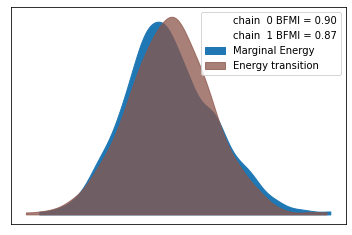

In [ ]:
az.plot_energy(normal_trace)

##### 3.2.2.2) WAIC/LOO/ELPD

In [ ]:
'''
ELPD (Expected log pointwise predictive density) is a measure of prediction 
accuracy and refers to the model's average predictive performance over the distribution
of unseen data. It can be estiamted using LOO cross-validation or WAIC. A higher
ELPD indicates better model performance.

LOOCV and WAIC are measures of out of sample predictive fit, and can be used to 
compare across models. A higher log score signifies a better model. LOOCV uses
Pareto-smoothed importance sampling (PSIS) and helps with marginal posterior predictive
checks, which can be helpful for detecting outliers in the data. 

LOO metrics are generally preferred over WAIC.
'''

In [ ]:
pm.waic(normal_trace)

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 607 log-likelihood matrix

          Estimate       SE
elpd_waic -4160.39    20.04
p_waic       14.38        -

There has been a warning during the calculation. Please check the results.

In [ ]:
pm.loo(normal_trace, pointwise = True)

Computed from 2000 by 607 log-likelihood matrix

         Estimate       SE
elpd_loo -4160.41    20.04
p_loo       14.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      607  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### 3.2.3) Error Metrics

In [ ]:
'''
To calculate error metrics, we need to first generate predictions from the model
to compare to the actual observed data.

In order to obtain predictions, we use the average estimates from each variable's
posterior distribution to use as our mean estimate. From there, we generate fitted
values and model residuals.
'''

"\nTo calculate error metrics, we need to first generate predictions from the model\nto compare to the actual observed data.\n\nIn order to obtain predictions, we use the average estimates from each variable's\nposterior distribution to use as our mean estimate. From there, we generate fitted\nvalues and model residuals.\n"

In [ ]:
'''
First, create a dictionary with an entry for each parameter estimate and the 
corresponding mean value taken from the posterior distributions.
'''

var_dict = {}
for variable in model_trace.varnames:
  var_dict[variable] = model_trace[variable]
  
# Results into a dataframe
var_weights = pd.DataFrame(var_dict)

# Means for all the weights
var_means = var_weights.mean(axis=0)

In [ ]:
var_means

Intercept_log__       7.718724
beta1_log__           1.125097
beta2_log__           2.763975
beta3_log__           5.091864
beta4_log__           3.707955
beta5_log__           3.574427
beta6_log__           5.395708
beta7_log__           1.476473
beta8_log__           4.551593
beta9_log__           1.721674
beta10_log__          0.594244
beta11_log__         -0.354275
beta12_log__          0.350163
beta13_log__          0.662924
beta14_log__          0.520514
beta15_log__          1.249053
beta16_log__          0.349812
beta17_log__          1.112178
beta18_log__          3.548550
beta19_log__          1.277335
beta20_log__          0.852880
beta21_log__          0.083847
beta22_log__          1.959235
beta23_log__          1.962088
beta24_log__          0.734009
beta25_log__          3.648277
beta26_log__          2.545713
sigma_log__           5.423335
Intercept          2250.106544
beta1                 5.290764
beta2                20.960656
beta3               163.413338
beta4   

In [ ]:
'''
Generate predictions with the obtained parameter estimate and the data
'''
Y_pred = (var_means['Intercept']*x.Intercept) + (var_means['beta1'] *x['x8']) + (var_means['beta2'] *x['x9']) + (var_means['beta3'] *x['x10']) + (var_means['beta4'] *x['x11']) + (var_means['beta5'] *x['x12']) + (var_means['beta6'] *x['x14']) + (var_means['beta7'] *x['x16']) + (var_means['beta8'] *x['x26']) + (var_means['beta9'] *x['x27']) + (var_means['beta10'] *x['x28']) + (var_means['beta11'] *x['x29']) + (var_means['beta12'] *x['x30']) + (var_means['beta13'] *x['x32']) +  (var_means['beta14'] *x['x33']) + (var_means['beta15'] *x['x34'])+ (var_means['beta16'] *x['x35']) + (var_means['beta17'] *x['x37']) + (var_means['beta18'] *x['x38']) + (var_means['beta19'] *x['x39'])+ (var_means['beta20'] *x['x40']) + (var_means['beta21'] *x['x41']) + (var_means['beta22'] *x['x42']) + (var_means['beta23'] *x['x43'])+ (var_means['beta22'] *x['x44']) + (var_means['beta23'] *x['x45']) + (var_means['beta24'] *x['x46']) 


In [ ]:
'''
Create residuals as the difference between the predicted conversion data and the 
actual (Y_pred vs. y)
'''

residuals = Y_pred - y

##### 3.2.3.1) MAE

In [ ]:
mean_absolute_error(y,Y_pred)

181.27146466216905

##### 3.2.3.2) MSE

In [ ]:
mean_squared_error(y,Y_pred)

52404.28097956528

##### 3.2.3.3) RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(y,Y_pred))
rmse

228.91981342724634

##### 3.2.3.4) R-Squared

In [ ]:
az.r2_score(y, Y_pred)[0]

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:509: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py (511)

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 511:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:509: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 512:
def stats_variance_1d(data, ddof=0):
    <source elided>
    a_a, b_b = 0, 0
    for i in data:


0.7524292162373918

## 4) Calculate % importance for each tactic

In [ ]:
'''
Use the relativeImp package (https://pypi.org/project/relativeImp/)
Conducts key driver analysis to generate relative importance by feature in the model

The relativeImp function produces a raw relative importance and a normalized relative 
importance value. Raw relative importance sums to the r-squared of the linear model.
Normalized relative importance is scaled to sum to 1
'''

conversions = 'y1'
tactics = ['x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x16', 'x26', 'x27', 'x28','x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40','x41', 'x42', 'x43', 'x44', 'x45', 'x46']
relative_importance_results = relativeImp(df, outcomeName = conversions, driverNames = tactics)

In [ ]:
relative_importance_results

,driver,rawRelaImpt,normRelaImpt
0,x8,0.034740,4.183284
1,x9,0.057323,6.902568
2,x10,0.199940,24.075874
3,x11,0.012991,1.564380
4,x12,0.109312,13.162854
5,x14,0.179261,21.585884
6,x16,0.006538,0.787295
7,x26,0.008581,1.033263
8,x27,0.021014,2.530401
9,x28,0.008670,1.043982


## 5) Validate Linear Regression Model Assumptions

In [ ]:
'''
For any statistical model it is important to validate model assumptions.
With RBA, we validate the standard linear model assumptions of:
  - Linearity
  - Normality of errors
  - Absence of multicollinearity
  - Homoscedasticity


If any of the model assumptions fail, a different model specification, as well
as re-examination of the data should be considered

Incorrect model use can lead to unreliable results
'''

### 5.1) Linearity

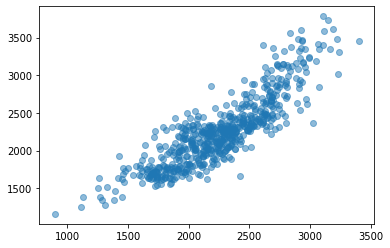

In [ ]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_pred,y,'o',alpha=0.5)
plt.show()

### 5.2) Normality of Errors

In [ ]:
'''
Visually inspect the residuals to confirm normality
'''

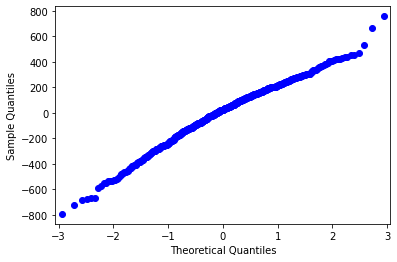

In [ ]:
fig = sm.qqplot(residuals)

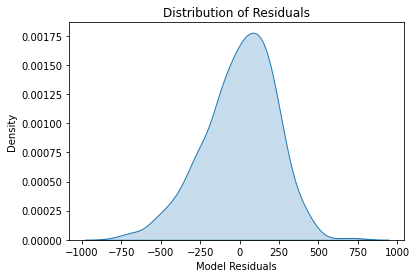

In [ ]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 5.3) Absence of Multicollinearity

In [ ]:
'''
Multicollinearity was checked and handled during data pre-processing stage
'''

### 5.4) Homoscedasticity


In [ ]:
'''
Visually inspect residuals to confirm constant variance
'''

In [ ]:
residuals.mean()

-0.046668190150049985

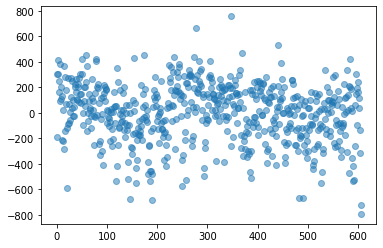

In [ ]:
plt.plot(residuals,'o',alpha=0.5)
plt.show()

## 6) Appendix

## 6.1) Parameterization Help

Use the `fitter` package to auto-detect the probability distribution of your data

In [ ]:
'''
sns.kdeplot(x[x.columns[3]], label = '', shade = True)
plt.xlabel(''); plt.ylabel('Density'); plt.title('Density Plot');

f = Fitter(x[x.columns[2]],
           distributions= get_common_distributions())
f.fit()
f.summary()

f.get_best(method = 'aic')
f.fitted_param['uniform']
'''